In [ ]:
import nannyml as nml
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

reference_df = nml.load_synthetic_binary_classification_dataset()[0]
analysis_df = nml.load_synthetic_binary_classification_dataset()[1]
analysis_target_df = nml.load_synthetic_binary_classification_dataset()[2]
analysis_df = analysis_df.merge(analysis_target_df, on='identifier')

column_names = [
    'distance_from_office', 'salary_range', 'gas_price_per_litre',
    'wfh_prev_workday', 'workday', 'tenure', 'public_transportation_cost',
]
univ_calc = nml.UnivariateDriftCalculator(
    column_names=column_names,
    timestamp_column_name='timestamp',
    continuous_methods=['jensen_shannon'],
    categorical_methods=['jensen_shannon'],
    chunk_size=5000
)

univ_calc.fit(reference_df)
univariate_results = univ_calc.calculate(analysis_df)

realized_calc = nml.PerformanceCalculator(
    y_pred_proba='y_pred_proba',
    y_pred='y_pred',
    y_true='work_home_actual',
    timestamp_column_name='timestamp',
    problem_type='classification_binary',
    metrics=['roc_auc'],
    chunk_size=5000)
realized_calc.fit(reference_df)
realized_perf_results = realized_calc.calculate(analysis_df)

ranker = nml.CorrelationRanker()
# ranker fits on one metric and reference period data only
ranker.fit(
    univariate_results.filter(period='reference'),
    realized_perf_results.filter(period='reference'))
# ranker ranks on one drift method and one performance metric
correlation_ranked_features = ranker.rank(
    univariate_results,
    realized_perf_results,
    only_drifting = False)
display(correlation_ranked_features)

,column_name,pearsonr_correlation,pearsonr_pvalue,has_drifted,rank
0,wfh_prev_workday,0.929710,3.076474e-09,True,1
1,public_transportation_cost,0.925910,4.872173e-09,True,2
2,salary_range,0.921556,8.014868e-09,True,3
3,distance_from_office,0.920749,8.762147e-09,True,4
4,gas_price_per_litre,0.340076,1.423541e-01,False,5
5,workday,0.154622,5.151128e-01,False,6
6,tenure,-0.177018,4.553046e-01,False,7


In [ ]:
print(correlation_ranked_features.to_markdown(tablefmt="grid"))

+----+----------------------------+------------------------+-------------------+---------------+--------+
|    | column_name                |   pearsonr_correlation |   pearsonr_pvalue | has_drifted   |   rank |
+====+============================+========================+===================+===============+========+
|  0 | wfh_prev_workday           |               0.92971  |       3.07647e-09 | True          |      1 |
+----+----------------------------+------------------------+-------------------+---------------+--------+
|  1 | public_transportation_cost |               0.92591  |       4.87217e-09 | True          |      2 |
+----+----------------------------+------------------------+-------------------+---------------+--------+
|  2 | salary_range               |               0.921556 |       8.01487e-09 | True          |      3 |
+----+----------------------------+------------------------+-------------------+---------------+--------+
|  3 | distance_from_office       |           

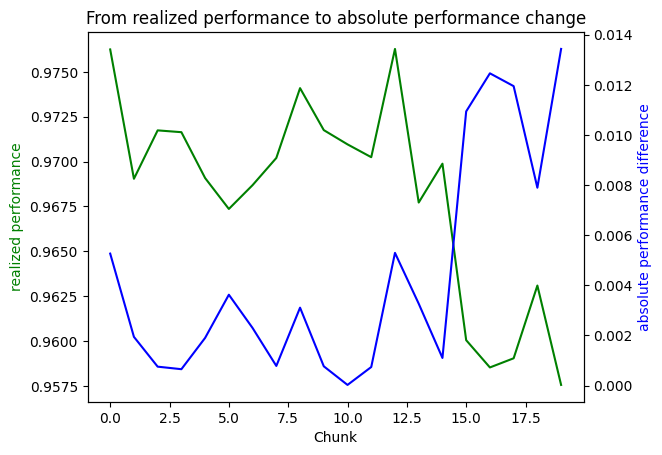

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(realized_perf_results.filter(period='all', metrics='roc_auc').to_df()['value'].to_numpy(), 'g-')
ax2.plot(ranker.absolute_performance_change, 'b-')
ax1.set_xlabel('Chunk')
ax1.set_ylabel('realized performance', color='g')
ax2.set_ylabel('absolute performance difference', color='b')
plt.title("From realized performance to absolute performance change")
plt.show()

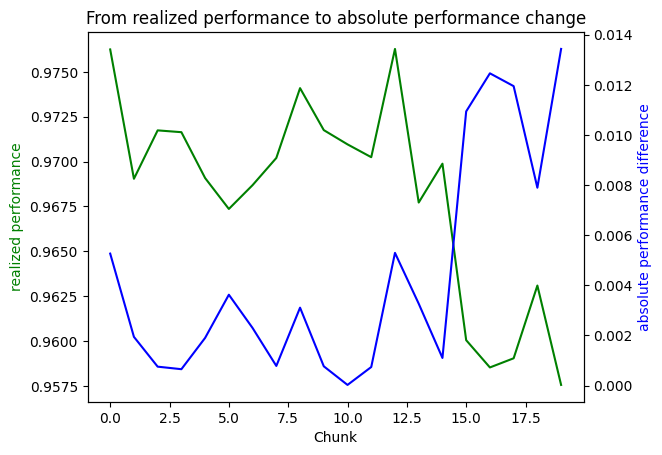

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(realized_perf_results.filter(period='all', metrics='roc_auc').to_df()['value'].to_numpy(), 'g-')
ax2.plot(ranker.absolute_performance_change, 'b-')
ax1.set_xlabel('Chunk')
ax1.set_ylabel('realized performance', color='g')
ax2.set_ylabel('absolute performance difference', color='b')
plt.title("From realized performance to absolute performance change")
plt.savefig("../_static/how-it-works-ranking-abs-perf.svg", bbox_inches='tight')

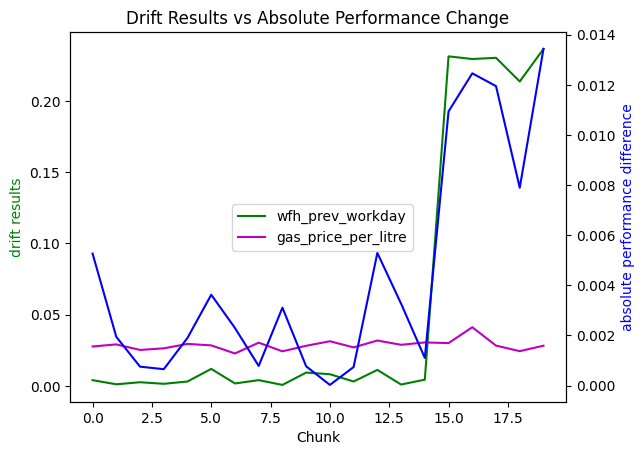

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.plot(ranker.absolute_performance_change, 'b-')
ax1.plot(
    univariate_results.filter(
        period='all', column_names=['wfh_prev_workday']
    ).to_df().loc[
        :, ('wfh_prev_workday', slice(None), 'value')
    ].to_numpy().ravel(),
    'g-', label='wfh_prev_workday'
)
ax1.plot(
    univariate_results.filter(
        period='all', column_names=['gas_price_per_litre']
    ).to_df().loc[
        :, ('gas_price_per_litre', slice(None), 'value')
    ].to_numpy().ravel(),
    'm-', label='gas_price_per_litre'
)
ax1.set_xlabel('Chunk')
ax1.set_ylabel('drift results', color='g')
ax2.set_ylabel('absolute performance difference', color='b')
fig.legend(loc="center")
plt.title("Drift Results vs Absolute Performance Change")
plt.show()

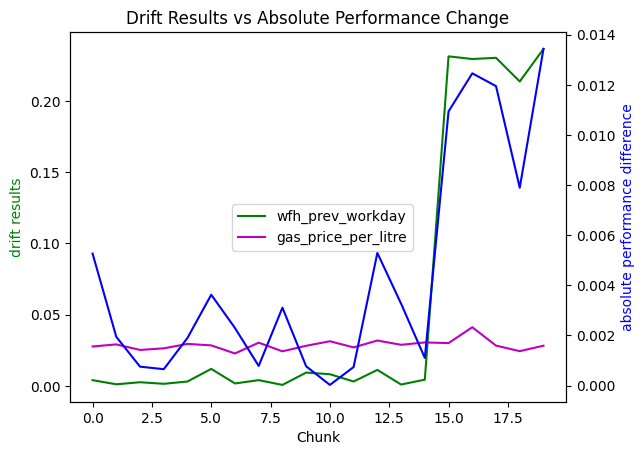

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.plot(ranker.absolute_performance_change, 'b-')
ax1.plot(
    univariate_results.filter(
        period='all', column_names=['wfh_prev_workday']
    ).to_df().loc[
        :, ('wfh_prev_workday', slice(None), 'value')
    ].to_numpy().ravel(),
    'g-', label='wfh_prev_workday')
ax1.plot(
    univariate_results.filter(
        period='all', column_names=['gas_price_per_litre']
    ).to_df().loc[
        :, ('gas_price_per_litre', slice(None), 'value')
    ].to_numpy().ravel(),
    'm-', label='gas_price_per_litre')
ax1.set_xlabel('Chunk')
ax1.set_ylabel('drift results', color='g')
ax2.set_ylabel('absolute performance difference', color='b')
fig.legend(loc="center")
plt.title("Drift Results vs Absolute Performance Change")
plt.savefig("../_static/how-it-works-ranking-abs-perf-features-compare.svg", bbox_inches='tight')#pad_inches=0.3)